In [ ]:
! nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# GoogleNet 的介绍和实现

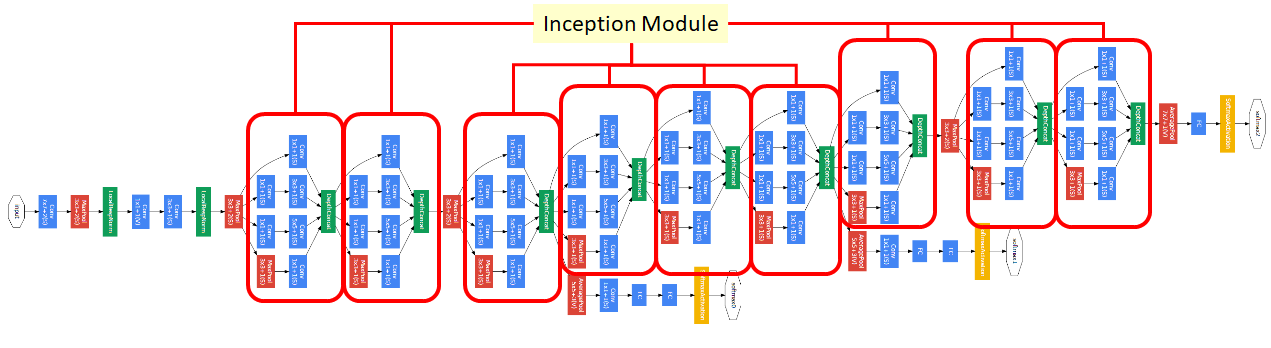

（1）引入Inception结构，通过不同尺度的卷积核池化结果的叠加，来获取不同尺度的特征信息。

（2）使用辅助分类器来帮助训练

（3）Inception结构的升级，使用1x1卷积核来降维，减少参数数量

（4）使用全局平均池化代替全连接层，降低模型参数

## Inception结构

inception.svg

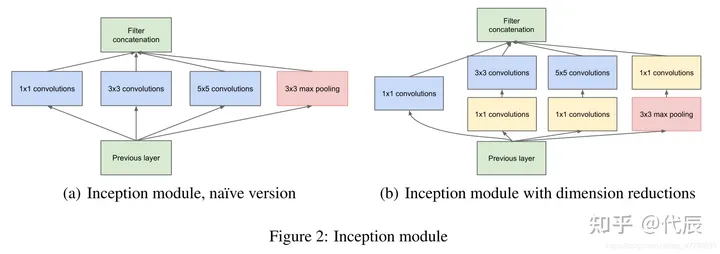

上图的左侧为Inception结构的初始版本，后为升级版本，区别在于后者使用1x1卷积来降低通道数量，以此降低卷积核参数数量

关于Inception结构：其核心思想在于，我们使用小卷积核在图像上滑动并且映射出的信息，可以视为输入数据的小尺度的特征，而如果使用大卷积核，那么得到的则是大尺度的特征，将不同大小尺度的特征融合可以更好学习到数据的信息。

在现在看来，卷积神经网络比较流行使用“深度”“小卷积核”“多通道”的形式，但是在GoogleNet的时代，普遍还是在讨论使用什么大小的卷积核合适，而googleNet的思想就是融合不同尺寸卷积核的优点。

注意，在输入经过四种不同的操作后，要求输出的H，W维度是相同的，在C通道维度将结果叠加

后续也出现了Inception V2 V3 V4 结构，此为V1

In [ ]:
class Inception(torch.nn.Module):
    def __init__(self,inchannels,ch1x1,ch3x3r,ch3x3,ch5x5r,ch5x5,pool_proj):
        super(Inception, self).__init__()
        self.batch1 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels,ch1x1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch2 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch3x3r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch3x3r,ch3x3,3,1,1),
            torch.nn.ReLU(inplace=True)
        )
        self.batch3 = torch.nn.Sequential(
            torch.nn.Conv2d(inchannels, ch5x5r, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(ch5x5r,ch5x5,5,1,2),
            torch.nn.ReLU(inplace=True)
        )
        self.batch4 = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, 1, 1),
            torch.nn.Conv2d(inchannels,pool_proj,1),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self,x):
        b1 = self.batch1(x)
        b2 = self.batch2(x)
        b3 = self.batch3(x)
        b4 = self.batch4(x)

        output = [b1,b2,b3,b4] # batch (ch1x1+ch3x3+ch5x5+pool_proj)

        return torch.cat(output, 1)

## V2

Inception V2在V1的基础上将大的卷积核进行分解。大尺寸的卷积核可以带来更大的感受野，但也意味着会产生更多的参数，比如5x5卷积核的参数有25个，3x3卷积核的参数有9个，前者是后者的25/9=2.78倍。

GoogLeNet团队提出可以用2个连续的3x3卷积层组成的小网络来代替单个的5x5卷积层，即在保持感受野范围的同时又减少了参数量。并且通过实验证明，大卷积核完全可以由一系列的3x3卷积核来替代。

再后来GoogLeNet团队考虑了1×n和nx1的卷积核，用1个1×3和一个3×1的卷积核取代3x3卷积，但是这种模式在中等大小的特征图上比较合适，在模型的前期不太好用。

## V3

## 辅助分类器

In [ ]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

# GoogleNet V1

## model

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):  # N x 3 x 224 x 224
        x = self.conv1(x)  # N x 64 x 112 x 112
        x = self.maxpool1(x)  # N x 64 x 56 x 56
        x = self.conv2(x)  # N x 64 x 56 x 56
        x = self.conv3(x)  # N x 192 x 56 x 56
        x = self.maxpool2(x)  # N x 192 x 28 x 28
        x = self.inception3a(x)  # N x 256 x 28 x 28
        x = self.inception3b(x)  # N x 480 x 28 x 28
        x = self.maxpool3(x)  # N x 480 x 14 x 14
        x = self.inception4a(x)  # N x 512 x 14 x 14

        if self.training and self.aux_logits:  # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)  # N x 512 x 14 x 14
        x = self.inception4c(x)  # N x 512 x 14 x 14
        x = self.inception4d(x)  # N x 528 x 14 x 14

        if self.training and self.aux_logits:  # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)  # N x 832 x 14 x 14
        x = self.maxpool4(x)  # N x 832 x 7 x 7
        x = self.inception5a(x)  # N x 832 x 7 x 7
        x = self.inception5b(x)  # N x 1024 x 7 x 7
        x = self.avgpool(x)  # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)  # N x 1024
        x = self.dropout(x)
        x = self.fc(x)  # N x 1000 (num_classes)

        if self.training and self.aux_logits:  # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)  # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            # 在官方的实现中，其实是3x3的kernel并不是5x5，这里我也懒得改了，具体可以参考下面的issue
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)  # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


## train

In [ ]:
import torch
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/gdrive/MyDrive/Data'
model = 'GoogLeNet'
mandate = 'flower'  # 'flower' 'hand'
save_path = model + '-' + mandate + '.pth'
init_weights = True
batch_size = 32
num_epoch = 30
learning_rate = 0.0003


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                                         transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                         transforms.ToTensor(),  # 图像转换成tensor格式
                                         transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "val": transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    data = mandate + '_data'
    image_path = os.path.join(data_root, data)  # 'D:/data/hand_data' 'D:/data/flower_data'
    # 确认文件路径存在
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format(data,model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    print("using {} test_images for training, {} test_images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    '''设置网络'''
    num_classes = 6 if mandate == 'hand' else 5
    net = GoogLeNet(num_classes=num_classes,aux_logits=True,init_weights=True)
    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam优化器
    best_acc = 0.0  # 最佳准确率
    for epoch in range(num_epoch):
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()

            logits, aux_logits2, aux_logits1 = net(images.to(device))
            loss0 = loss_function(logits, labels.to(device))
            loss1 = loss_function(aux_logits1, labels.to(device))
            loss2 = loss_function(aux_logits2, labels.to(device))
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)

        '''计算在测试集的准确率'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num  # 统计训练过程的平均损失
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / len(train_loader), val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == "__main__":
    main()


using cuda:0 device.
working in flower_data by GoogLeNet
using 3306 test_images for training, 364 test_images for validation.
Using 2 dataloader workers every process
100%|██████████| 12/12 [00:56<00:00,  4.75s/it]
[epoch 1] train_loss: 3.980  val_accuracy: 0.516
100%|██████████| 12/12 [00:01<00:00,  6.37it/s]
[epoch 2] train_loss: 1.749  val_accuracy: 0.624
100%|██████████| 12/12 [00:03<00:00,  3.83it/s]
[epoch 3] train_loss: 1.628  val_accuracy: 0.646
100%|██████████| 12/12 [00:01<00:00,  6.39it/s]
[epoch 4] train_loss: 1.527  val_accuracy: 0.692
100%|██████████| 12/12 [00:01<00:00,  6.41it/s]
[epoch 5] train_loss: 1.434  val_accuracy: 0.582
100%|██████████| 12/12 [00:03<00:00,  3.83it/s]
[epoch 6] train_loss: 1.384  val_accuracy: 0.673
100%|██████████| 12/12 [00:01<00:00,  6.34it/s]
[epoch 7] train_loss: 1.324  val_accuracy: 0.651
100%|██████████| 12/12 [00:02<00:00,  5.86it/s]
[epoch 8] train_loss: 1.310  val_accuracy: 0.714
100%|██████████| 12/12 [00:02<00:00,  4.60it/s]
[epoch 9]

## predict

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # load image
    img_path = ""
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # create model
    model = GoogLeNet(num_classes=5, aux_logits=False).to(device)

    # load model weights
    weights_path = ""
    assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
    missing_keys, unexpected_keys = model.load_state_dict(torch.load(weights_path, map_location=device),
                                                          strict=False)

    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()


# X-ray 数据集

## model

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):  # N x 3 x 224 x 224
        x = self.conv1(x)  # N x 64 x 112 x 112
        x = self.maxpool1(x)  # N x 64 x 56 x 56
        x = self.conv2(x)  # N x 64 x 56 x 56
        x = self.conv3(x)  # N x 192 x 56 x 56
        x = self.maxpool2(x)  # N x 192 x 28 x 28
        x = self.inception3a(x)  # N x 256 x 28 x 28
        x = self.inception3b(x)  # N x 480 x 28 x 28
        x = self.maxpool3(x)  # N x 480 x 14 x 14
        x = self.inception4a(x)  # N x 512 x 14 x 14

        if self.training and self.aux_logits:  # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)  # N x 512 x 14 x 14
        x = self.inception4c(x)  # N x 512 x 14 x 14
        x = self.inception4d(x)  # N x 528 x 14 x 14

        if self.training and self.aux_logits:  # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)  # N x 832 x 14 x 14
        x = self.maxpool4(x)  # N x 832 x 7 x 7
        x = self.inception5a(x)  # N x 832 x 7 x 7
        x = self.inception5b(x)  # N x 1024 x 7 x 7
        x = self.avgpool(x)  # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)  # N x 1024
        x = self.dropout(x)
        x = self.fc(x)  # N x 1000 (num_classes)

        if self.training and self.aux_logits:  # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)  # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            # 在官方的实现中，其实是3x3的kernel并不是5x5，这里我也懒得改了，具体可以参考下面的issue
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)  # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


## train

In [4]:
import torch
from torch import tensor
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/gdrive/MyDrive/Data/chest_xray'
model = 'GoogleNet'
init_weights = True
num_classes = 2
batch_size = 32
num_epoch = 10
learning_rate = 0.0001
save_path = '/content/gdrive/MyDrive/path/' + model + '-b' + str(batch_size) + '-e' + str(num_epoch) + 'chest_xray' + '.pth'

test_acc = []
train_acc = []
test_loss = []
train_loss = []


def main():
    global net
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                                         transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                         transforms.ToTensor(),  # 图像转换成tensor格式
                                         transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "test": transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    image_path = data_root
    # 确认文件路径存在
    assert os.path.exists(data_root), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format('chest_xray', model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "test"),
                                            transform=data_transform["test"])
    val_num = len(validate_dataset)
    print("using {} test_images for training, {} test_images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    '''设置网络'''
    net = GoogLeNet(num_classes=2,init_weights=True)

    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam优化器

    best_acc = 0.0  # 最佳准确率
    num = 0
    for epoch in range(num_epoch):
        if num == 0:
            # -----------------------------------------------------------
            '''计算在测试集的准确率与loss值'''
            net.eval()  # 在预测时关闭Dropout方法
            acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
            vrunning_loss = 0.0
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            with torch.no_grad():
                for val_data in val_bar:
                    val_images, val_labels = val_data
                    optimizer.zero_grad()
                    outputs = net(val_images.to(device))
                    loss = loss_function(outputs, val_labels.to(device))
                    vrunning_loss += loss.item()
                    predict_y = torch.max(outputs, dim=1)[1]
                    acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            val_accurate = acc / val_num
            test_acc.append(val_accurate)
            test_loss.append(vrunning_loss / len(validate_loader))
            # ----------------------------------------------------------
            # -----------------------------------------------------------
            '''计算在训练集的准确率与loss值'''
            net.eval()  # 在预测时关闭Dropout方法
            acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
            trunning_loss = 0.0
            with torch.no_grad():
                train_bar = tqdm.tqdm(train_loader, file=sys.stdout)
                for train_data in train_bar:
                    train_images, train_labels = train_data
                    outputs = net(train_images.to(device))
                    loss = loss_function(outputs, train_labels.to(device))
                    trunning_loss += loss.item()
                    predict_y = torch.max(outputs, dim=1)[1]
                    acc += torch.eq(predict_y, train_labels.to(device)).sum().item()
            train_accurate = acc / train_num
            train_acc.append(train_accurate)
            train_loss.append(trunning_loss / len(train_loader))
            # -----------------------------------------------------------

        # -----------------------------------------------------------
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            logits, aux_logits2, aux_logits1 = net(images.to(device))
            loss0 = loss_function(logits, labels.to(device))
            loss1 = loss_function(aux_logits1, labels.to(device))
            loss2 = loss_function(aux_logits2, labels.to(device))
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)
        # -----------------------------------------------------------

        # -----------------------------------------------------------
        '''计算在测试集的准确率与loss值'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        vrunning_loss = 0.0
        val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
        with torch.no_grad():
            for val_data in val_bar:
                val_images, val_labels = val_data
                optimizer.zero_grad()
                outputs = net(val_images.to(device))
                loss = loss_function(outputs, val_labels.to(device))
                vrunning_loss += loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        test_acc.append(val_accurate)
        test_loss.append(vrunning_loss / len(validate_loader))
        num += 1
        # -----------------------------------------------------------

        # -----------------------------------------------------------
        '''计算在训练集的准确率与loss值'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        trunning_loss = 0.0
        with torch.no_grad():
            train_bar = tqdm.tqdm(train_loader, file=sys.stdout)
            for train_data in train_bar:
                train_images, train_labels = train_data
                outputs = net(train_images.to(device))
                loss = loss_function(outputs, train_labels.to(device))
                trunning_loss += loss.item()
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, train_labels.to(device)).sum().item()
        train_accurate = acc / train_num
        train_acc.append(train_accurate)
        train_loss.append(trunning_loss / len(train_loader))
        # -----------------------------------------------------------

        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f test_accuracy: %.3f ' %
              (epoch + 1, running_loss / len(train_loader), train_accurate, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

    print(test_acc)
    print(train_acc)
    print(test_loss)
    print(train_loss)


if __name__ == "__main__":
    main()






using cuda:0 device.
working in chest_xray by GoogleNet
using 5224 test_images for training, 624 test_images for validation.
Using 2 dataloader workers every process
100%|██████████| 164/164 [01:18<00:00,  2.09it/s]
[epoch 1] train_loss: 0.973  train_accuracy: 0.859 test_accuracy: 0.840 
100%|██████████| 164/164 [01:20<00:00,  2.05it/s]
[epoch 2] train_loss: 0.602  train_accuracy: 0.865 test_accuracy: 0.859 
100%|██████████| 164/164 [01:17<00:00,  2.11it/s]
[epoch 3] train_loss: 0.536  train_accuracy: 0.840 test_accuracy: 0.792 
100%|██████████| 164/164 [01:16<00:00,  2.15it/s]
[epoch 4] train_loss: 0.519  train_accuracy: 0.875 test_accuracy: 0.853 
100%|██████████| 164/164 [01:15<00:00,  2.17it/s]
[epoch 5] train_loss: 0.467  train_accuracy: 0.882 test_accuracy: 0.886 
100%|██████████| 164/164 [01:19<00:00,  2.05it/s]
[epoch 6] train_loss: 0.437  train_accuracy: 0.905 test_accuracy: 0.877 
100%|██████████| 164/164 [01:18<00:00,  2.10it/s]
[epoch 7] train_loss: 0.425  train_accuracy: 0